### Plots for the paper

In [1]:
################## IMPORT LIBRARIES ##################
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import soundfile as sf
from IPython.display import Audio, display, HTML
import torch
from os.path import join as pjoin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io.wavfile as wavfile
from scipy import stats



In [ ]:
# ANALYZE THE MUSHRA SAMPLES
filenames=[]
levels=[]

for i in range(0,10):
    for filename in glob.glob(os.path.join(f"../sounds/Mushra/Sample{i+1}/", '*.wav')):
        fs, x = wavfile.read(filename)
        x = x.astype(np.float32) / 32768.0 
        filenames.append(filename)
        levels.append(20*np.log10(np.sum(x**2))))

samples=pd.DataFrame([])
samples["filename"]=filenames
samples["level"]=levels
samples["condition"]=np.NaN


samples.loc[samples["filename"].str.contains("target"),"condition"]="target"
samples.loc[samples["filename"].str.contains("content"),"condition"]="content"
samples.loc[samples["filename"].str.contains("stft"),"condition"]="stft+wav"
samples.loc[samples["filename"].str.contains("logmel"),"condition"]="logmel+wav"
samples.loc[samples["filename"].str.contains("anecho"),"condition"]="anecho+fins"
samples.loc[samples["filename"].str.contains("dfnet"),"condition"]="dfnet+fins"
samples.loc[samples["filename"].str.contains("wpe"),"condition"]="wpe+fins"


pd.set_option('display.max_colwidth', None)  
samples.head(20)

display(samples.groupby("condition")["level"].mean())

condition
anecho+fins   -18.179980
content       -18.947364
dfnet+fins    -18.306132
logmel+wav    -19.133091
stft+wav      -18.359222
target        -19.233473
wpe+fins      -17.635574
Name: level, dtype: float64

In [4]:

# Load the dataset
file_path = "mushra_Test-20250321163156199336.csv"
df = pd.read_csv(file_path,header=None)

df=df.iloc[1:,3:].T.reset_index()

df.rename(columns={df.columns[1]: "audio_file"}, inplace=True)
df.rename(columns={df.columns[2]: "trial"}, inplace=True)
for i in range(3, len(df.columns)):
    df.rename(columns={df.columns[i]: f"user{i-2}"}, inplace=True)


df["trial"]=df["trial"].fillna(method='ffill', limit=6)

df["condition"]=np.nan
df.loc[df["audio_file"].str.contains("target"),"condition"]="target"
df.loc[(df["audio_file"].str.contains("stft") & df["audio_file"].str.contains("prediction")),"condition"]="stft+wav"
df.loc[(df["audio_file"].str.contains("logmel") & df["audio_file"].str.contains("prediction")),"condition"]="logmel+wav"
df.loc[(df["audio_file"].str.contains("anecho") & df["audio_file"].str.contains("prediction")),"condition"]="anecho+fins"
df.loc[(df["audio_file"].str.contains("dfnet") & df["audio_file"].str.contains("prediction")),"condition"]="dfnet+fins"
df.loc[(df["audio_file"].str.contains("wpe") & df["audio_file"].str.contains("prediction")),"condition"]="wpe+fins"
df.loc[df["audio_file"].str.contains("content"),"condition"]="content"

df["revdiff"]=np.nan
df.loc[df["trial"].str.contains("9"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("5"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("4"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("6"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("8"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("1"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("3"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("7"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("10"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("2"),"revdiff"]="dry2rev"



# df = df[~df["trial"].isin(["Audio Example 9 rating", "Audio Example 10 rating"])]
df = df[~df["trial"].isin(["Audio Example 10 rating"])]

In [5]:
# Reshape the data using pivot_table
pivot_df = df.melt(id_vars=['condition',"trial","revdiff"], value_vars=['user1', 'user2', 'user3', 'user4', 'user5', 'user6','user7','user8',"user9","user10"],
                   var_name='user', value_name='score')

pivot_df["score"]= pd.to_numeric(pivot_df["score"], errors='coerce')

pivot_df.head(10)


,condition,trial,revdiff,user,score
0,content,Audio Example 1 rating,dry2rev,user1,0
1,stft+wav,Audio Example 1 rating,dry2rev,user1,100
2,logmel+wav,Audio Example 1 rating,dry2rev,user1,0
3,anecho+fins,Audio Example 1 rating,dry2rev,user1,81
4,dfnet+fins,Audio Example 1 rating,dry2rev,user1,40
5,wpe+fins,Audio Example 1 rating,dry2rev,user1,22
6,target,Audio Example 1 rating,dry2rev,user1,100
7,content,Audio Example 2 rating,dry2rev,user1,0
8,stft+wav,Audio Example 2 rating,dry2rev,user1,20
9,logmel+wav,Audio Example 2 rating,dry2rev,user1,0


In [ ]:
print("content vs stft+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "content","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))
print("stft+wav vs logmel+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"]))
print("logmel+wav vs wpe+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"]))
print("wpe+fins vs dfnet+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("logmel+wav vs dfnet+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("dfnet+fins vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("stft+wav vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs stft+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))




content vs stft+wav
Ttest_indResult(statistic=-20.772951260411475, pvalue=1.8787171775192186e-49)
stft+wav vs logmel+wav
Ttest_indResult(statistic=5.632673767028316, pvalue=6.819437985005882e-08)
logmel+wav vs wpe+fins
Ttest_indResult(statistic=6.742257926567412, pvalue=2.0982777804150615e-10)
wpe+fins vs dfnet+fins
Ttest_indResult(statistic=-7.587115085283593, pvalue=1.756162916945867e-12)
logmel+wav vs dfnet+fins
Ttest_indResult(statistic=0.042144741924342, pvalue=0.9664305497830912)
dfnet+fins vs anecho+fins
Ttest_indResult(statistic=-4.314244158742814, pvalue=2.6506063699488833e-05)
stft+wav vs anecho+fins
Ttest_indResult(statistic=2.0849665354266964, pvalue=0.0384992120703603)
target vs anecho+fins
Ttest_indResult(statistic=9.327488977677454, pvalue=4.279306321751774e-17)
target vs stft+wav
Ttest_indResult(statistic=7.0246717751811465, pvalue=4.382630244860432e-11)


/tmp/ipykernel_514642/3977802074.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.1, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")


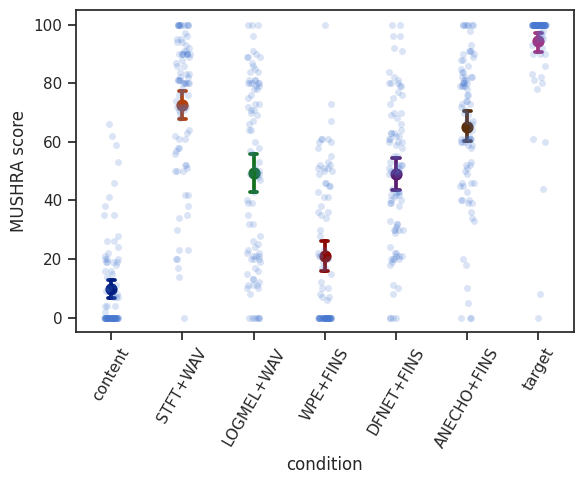

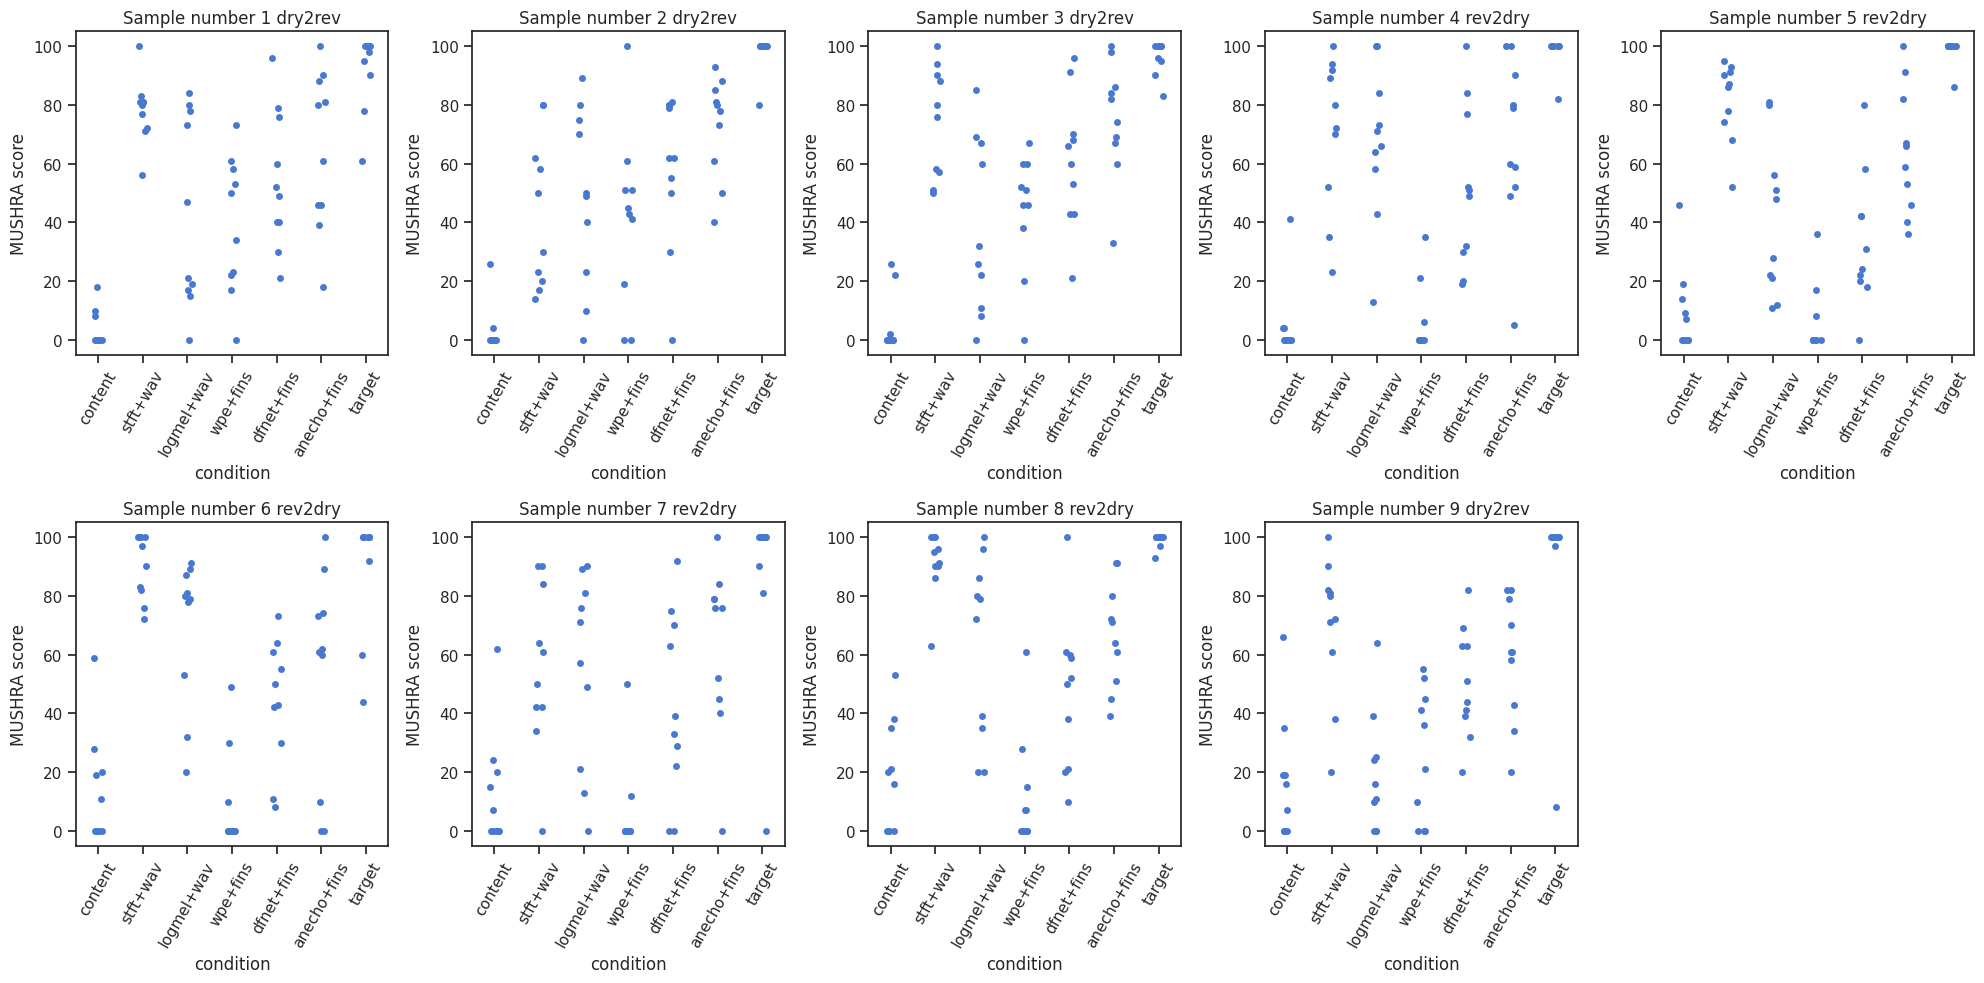

,index,condition,trial,revdiff,user,score
0,56,target,Audio Example 9 rating,dry2rev,user1,100
1,57,content,Audio Example 9 rating,dry2rev,user1,0
2,58,stft+wav,Audio Example 9 rating,dry2rev,user1,20
3,59,logmel+wav,Audio Example 9 rating,dry2rev,user1,0
4,60,wpe+fins,Audio Example 9 rating,dry2rev,user1,41
...,...,...,...,...,...,...
65,625,stft+wav,Audio Example 9 rating,dry2rev,user10,61
66,626,logmel+wav,Audio Example 9 rating,dry2rev,user10,39
67,627,wpe+fins,Audio Example 9 rating,dry2rev,user10,55
68,628,dfnet+fins,Audio Example 9 rating,dry2rev,user10,63


In [55]:
# print(pivot_df.groupby("condition").mean(numeric_only=True))
# print(pivot_df.groupby("condition").std(numeric_only=True))

sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "stft+wav", "logmel+wav", "wpe+fins", "dfnet+fins", "anecho+fins", "target"]
myxticks=["content", "STFT+WAV", "LOGMEL+WAV", "WPE+FINS", "DFNET+FINS", "ANECHO+FINS", "target"]
plt.figure(figsize=(6,5))
sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.1, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")
sns.stripplot(data=pivot_df, x="condition", y="score", order=condition_order,alpha=0.2)
plt.xticks(np.arange(7),myxticks,rotation=60)
plt.ylabel("MUSHRA score")
plt.title(f"")
plt.tight_layout()
plt.savefig('mushraA.pdf', format='pdf')
plt.show()




sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "stft+wav", "logmel+wav", "wpe+fins", "dfnet+fins", "anecho+fins", "target"]

plt.figure(figsize=(20,10))
# setting font sizeto 30
for i in range(0,9):
    one_example=pivot_df[pivot_df["trial"]==f"Audio Example {i+1} rating"].reset_index()
    r=one_example["revdiff"][0]
    plt.subplot(2,5,i+1)
    sns.stripplot(data=one_example, x="condition", y="score", order=condition_order)
    plt.ylabel("MUSHRA score")
    plt.xticks(rotation=60)
    plt.title(f"Sample number {i+1} " + r)
plt.tight_layout()
plt.show()



one_example